In [1]:
using FastGaussQuadrature, QuadGK
using Distributions, StatsPlots, StatsFuns
using Interact, Plots, LaTeXStrings, WebIO

WebIO._IJuliaInit()

# Homework: Gaussian Quadrature Integration

###### GH: Gauss-Hermite; GL: Gauss-Legendre; GLa: Gauss-Laguerre

For all the problems, you may obtain $\{\omega_i, \xi_i \}$ directly from Julia's `FastGaussQuadrature` packages. For instance, `xi, wi = gausslegendre(20)` would give $\{\omega_i, \xi_i \}$, $i=1,\ldots,20$, from the Gauss-Legendre rule.

## This problem asks you to adopt the Gauss-Hermite rule to an infinite integral where the weight function does not match.  The integration problem is:
  $$\begin{aligned}
   I = \int_{-\infty}^\infty g(x) d x =  \int_{-\infty}^\infty \exp\left(-\frac{1}{3}x^2\right)\sqrt{1+x^2} dx.
  \end{aligned}$$ 
 

- ##### Let's do this without using changes of variables. 
  - Transform $g(x)$ to $e^{-x^2}f(x)$ so that the Gauss-Hermite rule could be applied. Write down the re-formulated integration problem explicitly and write down $f(x)$ explicitly.
  - Write Julia code to integrate the function numerically.

  $$\begin{aligned}
   f(x) = e^{(\frac{2}{3}x^2)}*\sqrt{1+x^2}
  \end{aligned}$$ 

In [2]:
g(x) = exp(-1/3*x^2)*sqrt(1+x^2)
f(x) = exp(2/3*x^2)*sqrt(1+x^2)

f (generic function with 1 method)

In [3]:
quadgk(g, -Inf, Inf, rtol=1e-6)[1] #using quadgk

4.5638130066205616

In [4]:
xi,wi = gausshermite(20) #using Gauss-Hermite rule 
answer = sum( wi .* f.(xi))

4.563801822412564

## Write a Julia function with the following specifications.
  - It calculates $E[g(y)]$ for any arbitrary $g(y)$ where $y \sim N(\mu, \sigma^2)$.
  - User's inputs include $g(y)$, $\mu$, $\sigma^2$, and $n$.
  - You may obtain $\{\omega_i, \xi_i\}$ directly from Julia's package.
  - If $g(y) = 1 + 3y + y^2$, $y \sim N(1,2)$, and $n=30$, the interface could be like `myInteg(1 + 3y + y^2, mean=1, variance=2, n=30)`, or, `myInteg(g, mean=1, variance=2, n=30)`.
  - Hint: You may define the probability density function of $y$ using the `Distributions` package and then `pdf(Normal(mean, std.dev.),x)`.

In [5]:
g(y) = 1 + 3y + y^2
function Expect_value(f, dist , n=1000)
    data = rand(dist,n)
    return mean(f.(data)),var(f.(data))
end

Expect_value (generic function with 2 methods)

In [6]:
println("Expect value:", Expect_value(g, Normal(1,sqrt(2)))[1],"\nvariance:",Expect_value(g, Normal(1,sqrt(2)))[2])

Expect value:7.110020717496985
variance:56.41963940525608


In [7]:
function myInteg(g::Function , u, sigma2, n)
    xi,wi = gausshermite(n)
    f(y) = g(y)*pdf(Normal(u, sqrt(sigma2)),y)/exp(-y^2)
    answer = sum( wi .* f.(xi))
    return answer
end

myInteg (generic function with 1 method)

In [8]:
myInteg(g, 1, 2, 30)

6.999792968988663

## It is generally true that proper integrals (i.e., with finite domains) are numerically easier to deal with. But what if a problem is naturally a GH type with an infinite domain and we transform it to a GL problem with a finite domain? Is the GL rule better in this scenario? Let's find out the answer. Consider the following integration problem which is often encountered in econometric analysis. 

$$\begin{aligned}
      I = \int_{-\infty}^\infty \Phi\left(\frac{x-a}{b}\right)\phi(x) dx,
\end{aligned}$$

where $X\sim N(0,1)$ is a standard normal random variable, $\phi(z)$ is the density function (PDF) of a random variable $z$, and $\Phi(z)$ is the CDF of $z$.
   - ##### Write a Julia function that uses the GH rule to approximate the integral. The program should be a function of $a$ and $b$.
   - ##### Transform this problem to the GL type. What is the transformation rule and what is the Jacobian? Type the equations and show your work.
   - ##### Write a Julia function that uses the GL rule to approximate the integral. The program should be a function of $a$ and $b$.
   - ##### Suppose the required precision is 6 digits after the decimal. Compare the performances of these functions. Which one converges more quickly (smaller $n$)? You may pick values of $a$ and $b$ to do the comparison. You may draw graphs to compare the results.
   - ##### Based on your results, is the GL rule always the most efficient?

In [9]:
function GH(a=0,b=1, n=20)
    xi,wi = gausshermite(n)
    z(x) = (x-a)/b
    f(x) = cdf(Normal(0, 1),z(x))*pdf(Normal(0, 1),x)/exp(-x^2)
    answer = sum( wi .* f.(xi))
    f2(x) = cdf(Normal(0, 1),z(x))*pdf(Normal(0, 1),x)
    return answer, quadgk(f2, -Inf, Inf, rtol=1e-6)[1]
end

GH (generic function with 4 methods)

transformation rule:$$x = \frac{t}{1-t^2}$$        Jacobian: $$\frac{t^2 + 1}{(t^2 -1)^2}$$

In [10]:
function GL(a=0,b=1, n=20)
    xi,wi = gausslegendre(n)
    t_to_x(t) = t/(1-t^2) 
    #x = t_to_x(t)
    J(t) = (t^2+1)/(t^2-1)^2
    z(x) = (x-a)/b
    f(t) = cdf(Normal(0, 1), z(t_to_x(t))) * pdf(Normal(0, 1), t_to_x(t))* J(t)
    answer = sum( wi .* f.(xi))
    return answer , quadgk(f, -1, 1, rtol=1e-6)[1]
end

GL (generic function with 4 methods)

In [11]:
function converges_number(f::Function;a=0,b=1)
    count=1
    while true
        g=f(a,b,count)
        if abs(g[1]-g[2]) < 1e-6
            print("n=",count)
            break
        end
        count+=1
    end
end

converges_number (generic function with 1 method)

In [12]:
converges_number(GH)

n=12

In [13]:
converges_number(GL)

n=35

In [14]:
function converges_number_plot(f1::Function,f2::Function;a=0,b=1)
    x = []
    g1value = []
    g2value = []
    count=1
    while true
        g1=f1(a,b,count)
        g2=f2(a,b,count)
        
        if (abs(g1[1]-g1[2]) < 1e-6) & (abs(g2[1]-g2[2]) < 1e-6)
            return g1value, g2value, x
            break
        end
        push!(x, count)
        push!(g1value, g1[1])
        push!(g2value, g2[1])


        if count > 1000
            #print("can not converge.")
            return g1value, g2value, x
            break
        end
        count+=1
    end
end

converges_number_plot (generic function with 1 method)

In [15]:
@manipulate for a in (-5:0.2:5) , b in (0.1:0.2:5)
    point = converges_number_plot(GL,GH,a=a,b=b)
    plot(point[3],point[1],label="GL",ylim=[0,1], xlim=[0,30])
    plot!(point[3],point[2],label="GH")
    f(x) = cdf(Normal(0, 1),(x-a)/b)*pdf(Normal(0, 1),x)
    plot!([quadgk(f, -Inf, Inf, rtol=1e-6)[1]], seriestype="hline" ,label = "target")
end   

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["a"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 51, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
26, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\User\\.julia\\packages\\Knockout\\HReiN\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\User\\.julia\\packages\\Knockout\\HReiN\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\User\\.julia\\packages\\InteractBase\\Qhvxg\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\User\\.julia\\packages\\InteractBase\\Qhvxg\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\User\\.julia\\packages\\Interact\\PENUy\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000007ac85f50, Task (runnable) @0x000000007ac85f50), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-5.0\",\"-4.8\",\"-4.6\",\"-4.4\",\"-4.2\",\"-4.0\",\"-3.8\",\"-3.6\",\"-3.4\",\"-3.2\",\"-3.0\",\"-2.8\",\"-2.6\",\"-2.4\",\"-2.2\",\"-2.0\",\"-1.8\",\"-1.6\",\"-1.4\",\"-1.2\",\"-1.0\",\"-0.8\",\"-0.6\",\"-0.4\",\"-0.2

GL rule is not always the most efficient.

## This problem asks you to consider an integration problem where it can be transformed to different types to use different Gaussian quadrature rules. Which one is the best? The integration problem is:

 $$\begin{aligned}
 \int_{a}^\infty \exp\left(-\frac{1}{100}x^2\right)(1+x^2) dx,
 \end{aligned}$$

where $a$ is finite but not necessarily 0. This problem has some characteristics of the GLa and GH types: It has an exponential function, and by mapping $a$ to $-1$, $0$ or $-\infty$ via change of variables, the domain would be of the GL, GLa and GH types, respectively. You are asked to perform the approximation using rules of each of the types and compare the performance. In the code, make $a$ a parameter that we can assign a value to it.

 - ##### Write Julia code that uses the GL rule to approximate the integral. 
 - ##### Write Julia code that uses the GLa rule to approximate the integral. 
 - ##### Write Julia code that uses the GH rule to approximate the integral. 
 - ##### Suppose the required precision is 6 digits after the decimal. Compare the performances of these functions; drawing a graph will be useful. You may pick a value for $a$ in the comparison. 
 - ##### According to your result above, which rule converges more quickly (smaller $n$)? What is the intuition behind the result?

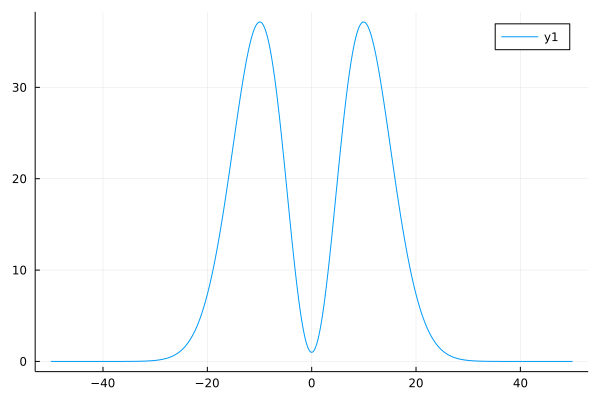

In [16]:
x = range(-50, 50, length=10000)
g(x) = exp(-1/100*x^2)*(1+x^2)
y=g.(x)
plot(x, y)

In [17]:
function approx_g(a,n=100)
    g(x) = exp(-1/100*x^2)*(1+x^2)
    if a == -1
        ##################################### GL
        xi,wi = gausslegendre(n)
        x(t) = a + (1+t)/(1-t)
        J(t) = 2/(t-1)^2
        fgl_neg_1(t) = g(x(t))*J(t)
        answergl = sum( wi .* fgl_neg_1.(xi))
        ##################################### GLa 平移
        xi,wi = gausslaguerre(n)
        g2(x) = exp(-1/100*(x-1)^2)*(1+(x-1)^2) # 平移
        fgla_neg_1(x) = g2(x)/exp(-x)
        answergla = sum( wi .* fgla_neg_1.(xi))
        ####################################### GH
        function g3(x)
            if x > 0 return exp(-1/100*(x-1)^2)*(1+(x-1)^2)
            else return exp(-1/100*(-x-1)^2)*(1+(-x-1)^2)
            end
        end
        xi,wi = gausshermite(n)
        fgh_neg_1(x) = g3(x)/exp(-x^2)
        answergh = sum( wi .* fgh_neg_1.(xi))/2    
        return answergl, answergla,  answergh, quadgk(g, a, Inf, rtol=1e-6)[1]
    elseif a == 0 
        ##################################### GL
        xi,wi = gausslegendre(n)
        x_0(t) = a + (1+t)/(1-t)
        J_0(t) = 2/(t-1)^2
        fgl_0(t) = g(x_0(t))*J_0(t)
        answergl = sum( wi .* fgl_0.(xi))
        ##################################### GLa
        xi,wi = gausslaguerre(n)
        fgla_0(x) = g(x)/exp(-x)
        answergla = sum( wi .* fgla_0.(xi))
        ####################################### GH/2
        xi,wi = gausshermite(n)
        fh_0(x) = g(x)/exp(-x^2)
        answergh = sum( wi .* fh_0.(xi))/2
        return answergl, answergla,  answergh, quadgk(g, a, Inf, rtol=1e-6)[1]
    elseif a == -Inf
        #######################################  GL
        xi,wi = gausslegendre(n)
        xgl_inf(t) = t/(1-t^2)
        Jgl_inf(t) = (t^2+1)/(t^2-1)^2
        fgl_inf(t) = g(xgl_inf(t))*Jgl_inf(t)
        answergl = sum( wi .* fgl_inf.(xi))
        ####################################### GLa*2
        xi,wi = gausslaguerre(n)
        fgla_inf(x) = g(x)/exp(-x)
        answergla = sum( wi .* fgla_inf.(xi))*2  
        ####################################### GH
        xi,wi = gausshermite(n)
        fgh_inf(x) = g(x)/exp(-x^2)
        answergh = sum( wi .* fgh_inf.(xi))
        return answergl, answergla,  answergh, quadgk(g, a, Inf, rtol=1e-6)[1]
    end
end

approx_g (generic function with 2 methods)

In [18]:
@manipulate for a = (-1,0,-Inf) , n =(50:20:400) 
    plot([i for i in [1:n]], [approx_g(a,i)[1] for i in (1:1:n)],label = "GL" )
    plot!([i for i in [1:n]], [approx_g(a,i)[2] for i in (1:1:n)],label = "GLa" )
    plot!([i for i in [1:n]], [approx_g(a,i)[3] for i in (1:1:n)],label = "GH" )
    g(x) = exp(-1/100*x^2)*(1+x^2)
    plot!([quadgk(g, a, Inf, rtol=1e-6)[1]], seriestype="hline" ,label = "target")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["a"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :span), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text : key")))], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "click: function (){\$root.update(val)}, css: {'is-primary is-selected' : \$root.index() == val, 'interact-widget is-medium button ' : true}")))], Dict{Symbol, Any}(:attributes => ("data-bind" => "foreach : options_js"), :className => "buttons has-addons is-centered"))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}())], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("options_js" => (Observable{Vector{OrderedDict}} with 1 listeners. Value:
OrderedDict[OrderedDict{String, Any}("key" => "-1", "val" => 1, "id" => "idmNWo2l1U"), OrderedDict{String, Any}("key" => "0", "val" => 2, "id" => "idemnd6ga0"), OrderedDict{String, Any}("key" => "-Inf", "val" => 3, "id" => "idh7d8YGVq")], nothing), "index" => (Observable{Any} with 2 listeners. Value:
1, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\User\\.julia\\packages\\Knockout\\HReiN\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\User\\.julia\\packages\\Knockout\\HReiN\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\User\\.julia\\packages\\InteractBase\\Qhvxg\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\User\\.julia\\packages\\InteractBase\\Qhvxg\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\User\\.julia\\packages\\Interact\\PENUy\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any, Any}("options_js" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"options_js\"]()) ? (this.valueFromJulia[\"options_js\"]=true, this.model[\"options_js\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000005997e400, Task (runnable) @0x000000005997e400), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get(

GLa最有效率。GH比較沒有效率的原因是:g(x)在大部分的x上都趨近於0，而GL又扭曲太多。